In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.burn_with_fee import BurnWithFeeShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.miners.base import BaseMinerState
# from shortfall.network import *
from shortfall.network import REWARD_DECAY, BASELINE_GROWTH
from shortfall.network_mechafil import DEFAULT_NETWORK_CONFIG
from shortfall.network_mechafil import NetworkConfig as MechafilNetworkConfig
from shortfall.network_mechafil import NetworkState as MechafilNetworkState
from shortfall.network_mechafil import compute_mechafil_trajectories
from shortfall.strategy import *
from shortfall.consts import *
import shortfall.gradient.wrappers as wrappers

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.lines import Line2D

from datetime import date, timedelta

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from tqdm.auto import tqdm
from ipywidgets import *

In [3]:
sector_duration = 3 * YEAR + 1

In [4]:
PUBLIC_AUTH_TOKEN = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
network_shortfall_uptake = 0.2  # currently a noop

# Precompute various minting rate trajectories to speed up interactive views
renewal_rate = 0.6
fil_plus_rate = 0.8
rbp_onboarding_pib = 3

today_minus_two_days = date.today() - timedelta(days=2)
low_rbp = 3
ob_low = compute_mechafil_trajectories(
    PUBLIC_AUTH_TOKEN,
    start_date=today_minus_two_days,
    network_shortfall_rate=network_shortfall_uptake,
    simulation_len=sector_duration+1,
    rbp=low_rbp,
    rr=0.6,
    fpr=0.8,
    sector_duration=sector_duration
)

med_rbp = 6
ob_med = compute_mechafil_trajectories(
    PUBLIC_AUTH_TOKEN,
    start_date=today_minus_two_days,
    network_shortfall_rate=network_shortfall_uptake,
    simulation_len=sector_duration+1,
    rbp=med_rbp,
    rr=0.6,
    fpr=0.8,
    sector_duration=sector_duration
)

hi_rbp = 15
ob_hi = compute_mechafil_trajectories(
    PUBLIC_AUTH_TOKEN,
    start_date=today_minus_two_days,
    network_shortfall_rate=network_shortfall_uptake,
    simulation_len=sector_duration+1,
    rbp=hi_rbp,
    rr=0.6,
    fpr=0.8,
    sector_duration=sector_duration
)

Computing mechafil trajectories


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Finished computing mechafil trajectories
Computing mechafil trajectories


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Finished computing mechafil trajectories
Computing mechafil trajectories


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Finished computing mechafil trajectories


In [5]:
low_onboarding_network_config = \
    dataclasses.replace(DEFAULT_NETWORK_CONFIG, 
                        cil_df=ob_low,
                        token_lease_fee=0.0)

medium_onboarding_network_config = \
    dataclasses.replace(DEFAULT_NETWORK_CONFIG, 
                        cil_df=ob_med,
                        token_lease_fee=0.0)

high_onboarding_network_config = \
    dataclasses.replace(DEFAULT_NETWORK_CONFIG, 
                        cil_df=ob_hi,
                        token_lease_fee=0.0)

In [6]:
def repay_get_max_possible_shortfall(network_config, power, sector_duration, max_fee_reward_fraction):
    network = MechafilNetworkState(network_config)
    max_repayment_reward_fraction = 1 - max_fee_reward_fraction
    
    pledge_requirement = network.initial_pledge_for_power(power)
    expected_rewards = network.expected_reward_for_power(power, sector_duration)
    max_possible_shortfall = max_repayment_reward_fraction * expected_rewards
    
    max_possible_shortfall_frac = max_possible_shortfall/pledge_requirement
    
    # TODO: take this shortfall and get how much was burned
    repay_stats = wrappers.get_repay_stats(
        network_config, 
        power=power,
        max_fee_reward_fraction=max_fee_reward_fraction,
        sector_duration=3*YEAR+1, 
        shortfall_frac=max_possible_shortfall_frac*0.99, # avoid rounding errors
        miner_balance=0,
        stats_interval=DAY
    )
    burned_tokens = repay_stats[-1]['fee_burned']
    
    return max_possible_shortfall_frac, burned_tokens

def is_valid_shortfall_frac_burn(network_config, power, sector_duration, shortfall_pct_pow, shortfall_frac):
    burn_stats = wrappers.get_burn_stats(
        network_config, 
        power=power,                   
        shortfall_frac=shortfall_frac,
        shortfall_pct_pow=shortfall_pct_pow,
        max_shortfall_possible=0.999,
        sector_duration=sector_duration,
        stats_interval=DAY,
        miner_balance = 0,
    )
    if burn_stats[-1]['shortfall_pct'] < 1:
        return True
    else:
        return False
    
def burn_get_max_possible_shortfall(network_config, power, sector_duration, shortfall_pct_pow):
    possible_shortfall_fracs = np.linspace(0.01, 0.99, 100)
    ix_lo = 0
    ix_hi = len(possible_shortfall_fracs)
    
    # use a binary search to find the maximum possible shortfall
    while True:
        ix = int((ix_lo + ix_hi) / 2)
        if ix_lo > ix_hi or ix_hi < ix_lo:
            raise ValueError("Unknown state!")
        if ix-ix_lo <= 1 and ix_hi-ix <= 1:
            break
        
        S = possible_shortfall_fracs[ix]
        r = is_valid_shortfall_frac_burn(network_config, power, sector_duration, shortfall_pct_pow, S)
        if r:
            # means we can search higher
            ix_lo = ix
        else:
            # search lower
            ix_hi = ix
    max_possible_shortfall = possible_shortfall_fracs[ix]
    burn_stats = wrappers.get_burn_stats(
        network_config, 
        power=power,                   
        shortfall_frac=max_possible_shortfall*0.999, # avoid rounding errors
        shortfall_pct_pow=shortfall_pct_pow,
        max_shortfall_possible=0.99,
        sector_duration=sector_duration,
        stats_interval=DAY,
        miner_balance = 0,
    )
    return max_possible_shortfall, burn_stats[-1]['fee_burned']

In [14]:
option1_max_shortfall = {}
option1_burned_tokens = {}
option2_max_shortfall = {}
option2_burned_tokens = {}

rbp_onboard_vec = [3,6,15]
networking_config_vec = [low_onboarding_network_config, medium_onboarding_network_config, high_onboarding_network_config]
param_vec = np.linspace(0.1, 0.75, 11)

power = 50 # should be a noop
pbar = tqdm(total=len(networking_config_vec)*len(shortfall_pct_pow_vec))
for rbp_onboard, network_config in zip(rbp_onboard_vec, networking_config_vec):
    for p in param_vec:
        max_shortfall, burned_tokens = repay_get_max_possible_shortfall(network_config, power, sector_duration, p)
        k = '%d,%0.02f' % (rbp_onboard, p)
        option1_max_shortfall[k] = max_shortfall
        option1_burned_tokens[k] = burned_tokens
    
        max_shortfall, fee_burned = burn_get_max_possible_shortfall(network_config, power, sector_duration, p)
        k = '%d,%0.02f' % (rbp_onboard, p)
        option2_max_shortfall[k] = max_shortfall
        option2_burned_tokens[k] = fee_burned
        
        pbar.update(1)

  0%|          | 0/33 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


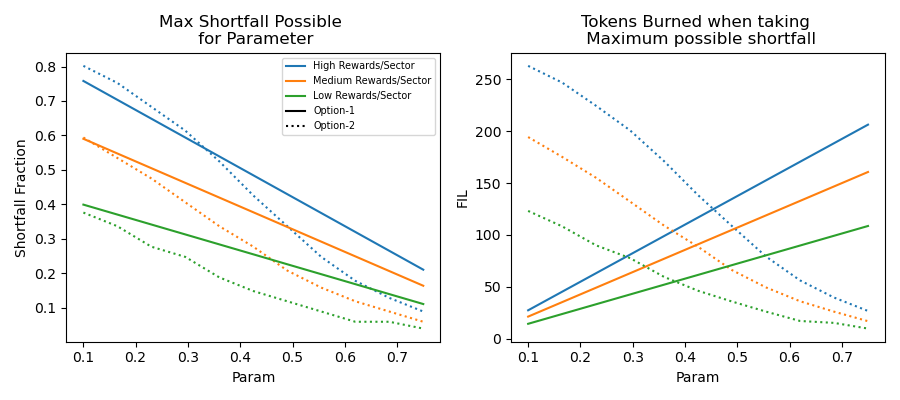

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(9,4))

legend_colors = []
for rbp in rbp_onboard_vec:
    max_shortfall_vec_option1 = []
    max_shortfall_vec_option2 = []
    for p in param_vec:
        max_shortfall_vec_option1.append(option1_max_shortfall['%d,%0.02f' % (rbp, p)])
        max_shortfall_vec_option2.append(option2_max_shortfall['%d,%0.02f' % (rbp, p)])
    
    if rbp == 3:
        rbp_str = 'High Rewards/Sector'
    elif rbp == 6:
        rbp_str = 'Med Rewards/Sector'
    elif rbp == 15:
        rbp_str = 'Low Rewards/Sector'
    p = ax[0].plot(param_vec, max_shortfall_vec_option1, label='Option-1 => %s' % (rbp_str,))
    ax[0].plot(param_vec, max_shortfall_vec_option2, color=p[0].get_color(), linestyle=':', label='Option-2 => %s' % (rbp_str,))
    legend_colors.append(p[0].get_color())
# plt.legend()
ax[0].set_xlabel('Param')
ax[0].set_ylabel('Shortfall Fraction')
ax[0].set_title('Max Shortfall Possible \n for Parameter')
custom_lines = [Line2D([0], [0], color=legend_colors[0]),
                Line2D([0], [0], color=legend_colors[1]),
                Line2D([0], [0], color=legend_colors[2]),
                Line2D([0], [0], color='k'),
                Line2D([0], [0], color='k', linestyle=':'),
               ]
ax[0].legend(custom_lines, 
           ['High Rewards/Sector', 
            'Medium Rewards/Sector', 
            'Low Rewards/Sector', 
            'Option-1', 
            'Option-2'], fontsize=7)


legend_colors = []
for rbp in rbp_onboard_vec:
    max_shortfall_vec_option1 = []
    max_shortfall_vec_option2 = []
    for p in param_vec:
        max_shortfall_vec_option1.append(option1_burned_tokens['%d,%0.02f' % (rbp, p)])
        max_shortfall_vec_option2.append(option2_burned_tokens['%d,%0.02f' % (rbp, p)])
        
    if rbp == 3:
        rbp_str = 'High Rewards/Sector'
    elif rbp == 6:
        rbp_str = 'Med Rewards/Sector'
    elif rbp == 15:
        rbp_str = 'Low Rewards/Sector'
    p = ax[1].plot(max_fee_reward_frac_vec, max_shortfall_vec_option1, label='Repay-RBP=%d => %s' % (rbp,rbp_str))
    ax[1].plot(shortfall_pct_pow_vec, max_shortfall_vec_option2, color=p[0].get_color(), linestyle=':', label='Burn-RBP=%d => %s' % (rbp,rbp_str))
    legend_colors.append(p[0].get_color())
# plt.legend()
ax[1].set_xlabel('Param')
ax[1].set_ylabel('FIL')
ax[1].set_title('Tokens Burned when taking \n Maximum possible shortfall')
plt.tight_layout()